In [54]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import random

# See if required packages are installed, and install them if not
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

mlxtend version: 0.23.1


In [37]:
# load training and testing datasets
train_data = datasets.FashionMNIST(
    root="data", # Where to download data to
    train=True, # Do we want training dataset
    download=True, # Do we want to download
    transform=ToTensor(), # How do we want to transform the data
    target_transform=None # How do we want to transform the labels
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [38]:
# Set up batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into Python iterables (batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
# Subclass nn.Module
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape))

  def forward(self, x):
    return self.layer_stack(x)

In [40]:
# Set manual seed
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=10).to("cpu")

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [41]:
# Epochs
EPOCHS = 3

#Train model on batches of data
for epoch in range(EPOCHS):
  print(f"Epoch: {epoch}\n---------")
  train_loss = 0

  # Loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss # Accumulate training loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {(batch + 1) * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss = train_loss / len(train_dataloader)

  # Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate cumulative loss
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc += (test_pred.argmax(dim=1) == y_test).sum().item()

    # Calculate test loss and accuracy average per batch
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader.dataset)

    # Print out what's happening
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}\n")

Epoch: 0
---------
Looked at 32/60000 samples
Looked at 12832/60000 samples
Looked at 25632/60000 samples
Looked at 38432/60000 samples
Looked at 51232/60000 samples

Train loss: 0.5880 | Test loss: 0.5247, Test acc: 0.8146

Epoch: 1
---------
Looked at 32/60000 samples
Looked at 12832/60000 samples
Looked at 25632/60000 samples
Looked at 38432/60000 samples
Looked at 51232/60000 samples

Train loss: 0.4764 | Test loss: 0.4768, Test acc: 0.8333

Epoch: 2
---------
Looked at 32/60000 samples
Looked at 12832/60000 samples
Looked at 25632/60000 samples
Looked at 38432/60000 samples
Looked at 51232/60000 samples

Train loss: 0.4548 | Test loss: 0.5511, Test acc: 0.8142



In [42]:
# Creating a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.layer_stack(x)

In [43]:
# Create an instance of model 1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, hidden_units=10, output_shape=10).to("cpu")

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [44]:
# Functionizing our training loop
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimzer: torch.optim.Optimizer):
  # Initialize loss and accuracy
  train_loss, acc = 0, 0

  #Set model to training mode
  model.train()

  # Loop through the training batches
  for batch, (X, y) in enumerate(dataloader):
    # 1. Forward pass
    y_pred = model(X)

    # 2. Aaccumulate loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    acc += (y_pred.argmax(dim=1) == y).sum().item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Adjust metrics
  train_loss /= len(dataloader)
  acc /= len(dataloader.dataset)

  # Print results
  print(f"Train loss: {train_loss:.4f} | Train acc: {acc:.4f}")

# Functionalizing our testing loop
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
  # Initialize loss and accuracy
  loss, acc = 0, 0

  # Set model to eval mode
  model.eval()

  # Turn on inference mode
  with torch.inference_mode():
    for X, y in dataloader:
      y_pred = model(X)

      # Accumulate loss and accuracy
      loss += loss_fn(y_pred, y)
      acc += (y_pred.argmax(dim=1) == y).sum().item()

    # Adjust metrics
    loss /= len(dataloader)
    acc /= len(dataloader.dataset)

  # Print results
  print(f"Test loss: {loss:.4f} | Test acc: {acc:.4f}")

In [45]:
# Create an eval function to avoid rewriting the evaluation step
# Returns a dictionary containing results of the model predicting on data_loader
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += (y_pred.argmax(dim=1) == y).sum().item()

    loss /= len(dataloader)
    acc /= len(dataloader.dataset)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [46]:
# Create a function to return the prediction labels
def make_predictions(model: torch.nn.Module, data: list):
  pred_probs = []

  # Set model to eval mode
  model.eval()

  # Turn on inference mode
  with torch.inference_mode():
    for sample in data:
      # Prepare sample (add batch dim)
      sample = torch.unsqueeze(sample, dim=0).to("cpu")

      # Forward pass
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Append prediction label
      pred_probs.append(pred_prob)

  # Return as a PyTorch stac
  return torch.stack(pred_probs)

In [47]:
# Rewrite our training steps with our new functions
EPOCHS = 3
for epoch in range(EPOCHS):
  print(f"Epoch: {epoch + 1}\n---------")
  train_step(model_1, train_dataloader, loss_fn, optimizer)
  test_step(model_1, test_dataloader, loss_fn)

Epoch: 1
---------
Train loss: 1.0920 | Train acc: 0.6134
Test loss: 0.9564 | Test acc: 0.6498
Epoch: 2
---------
Train loss: 0.7810 | Train acc: 0.7193
Test loss: 0.7223 | Test acc: 0.7389
Epoch: 3
---------
Train loss: 0.6703 | Train acc: 0.7594
Test loss: 0.6850 | Test acc: 0.7500


In [48]:
model_1_results = eval_model(model_1, test_dataloader, loss_fn)
print(model_1_results)
model_0_results = eval_model(model_0, test_dataloader, loss_fn)
print(model_0_results)

{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.6850009560585022, 'model_acc': 0.75}
{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.5511157512664795, 'model_acc': 0.8142}


In [49]:
# Create a CNN model
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the TinyVGG model from CNN explainer website
  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [50]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=10).to("cpu")

# Set up loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [51]:
# Train and test data
EPOCHS = 3
for epoch in range(EPOCHS):
  print(f"Epoch: {epoch + 1}\n---------")
  train_step(model_2, train_dataloader, loss_fn, optimizer)
  test_step(model_2, test_dataloader, loss_fn)

model_2_results = eval_model(model_2, test_dataloader, loss_fn)
print(model_2_results)

Epoch: 1
---------
Train loss: 0.5772 | Train acc: 0.7914
Test loss: 0.3915 | Test acc: 0.8589
Epoch: 2
---------
Train loss: 0.3564 | Train acc: 0.8720
Test loss: 0.3714 | Test acc: 0.8603
Epoch: 3
---------
Train loss: 0.3168 | Train acc: 0.8859
Test loss: 0.3331 | Test acc: 0.8773
{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.33307161927223206, 'model_acc': 0.8773}


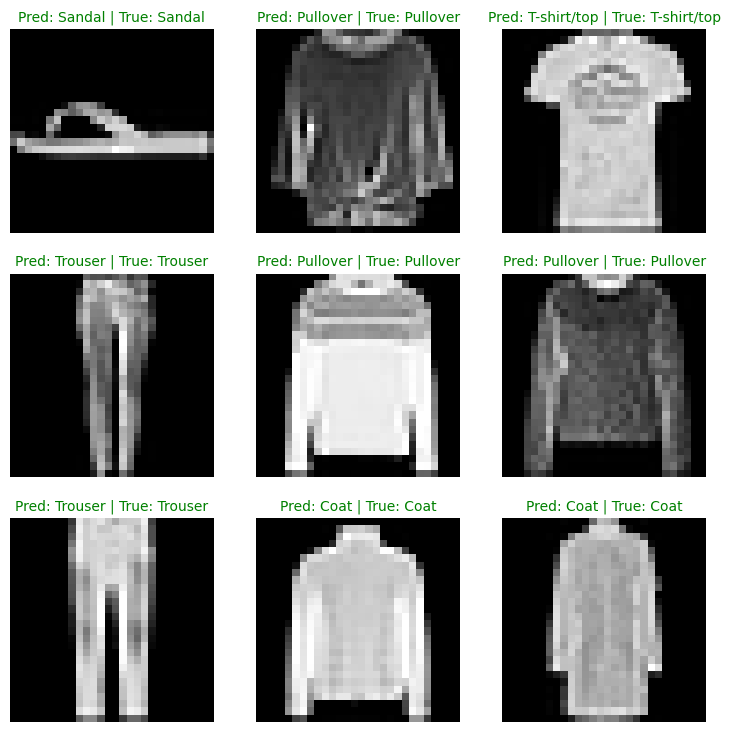

In [52]:
# Random sampling
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# Make predictions
pred_probs = make_predictions(model_2, test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = test_data.classes[pred_classes[i]]
  true_label = test_data.classes[test_labels[i]]
  title = f"Pred: {pred_label} | True: {true_label}"
  color = "green" if pred_label == true_label else "red"
  plt.title(title, fontsize=10, c=color)
  plt.axis(False)

In [62]:
# Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    # Forward pass
    y_logit = model_2(X)

    # Get prediction probability (logit -> prediction probability -> prediction label)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Append prediction label
    y_preds.append(y_pred)

  # Concatenate list of prediction labels
  y_preds = torch.cat(y_preds)

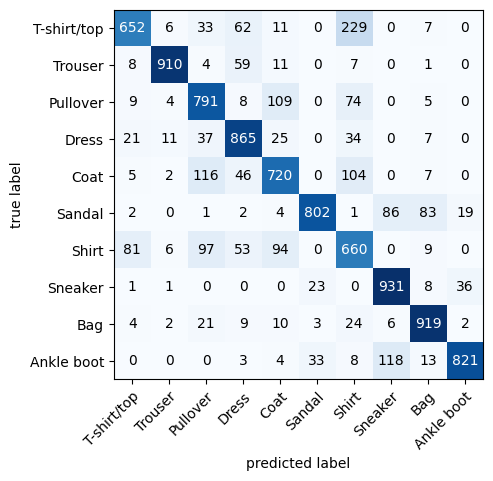

In [63]:
# Making a confusion matrix to compare predictions to targets
confmat = ConfusionMatrix(num_classes=10, task='MULTICLASS')
confmat_tensor = confmat(preds=y_preds, target=test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=test_data.classes
)

# A perfect confusion matrix will only have the diagonal fully darkened